## match open-field foragaing results to tree-maze results

In [65]:
%matplotlib inline

from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.plot_functions as pf
#import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf

import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from umap import UMAP
from sklearn.cluster import KMeans

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

In [3]:
o_flag = False
unit_table = info.get_unit_table(overwrite=o_flag)

In [4]:
pd.crosstab(unit_table.subject, unit_table.task)

task,OF,T3g,T3gj,T3i,T3j
subject,,,,,
Al,62,112,0,0,0
Ca,64,97,0,0,0
Cl,1043,916,0,47,0
Li,656,579,0,93,0
Mi,35,43,0,0,0
Ne,338,271,13,93,2


(<Figure size 2250x1500 with 1 Axes>, <AxesSubplot:>)

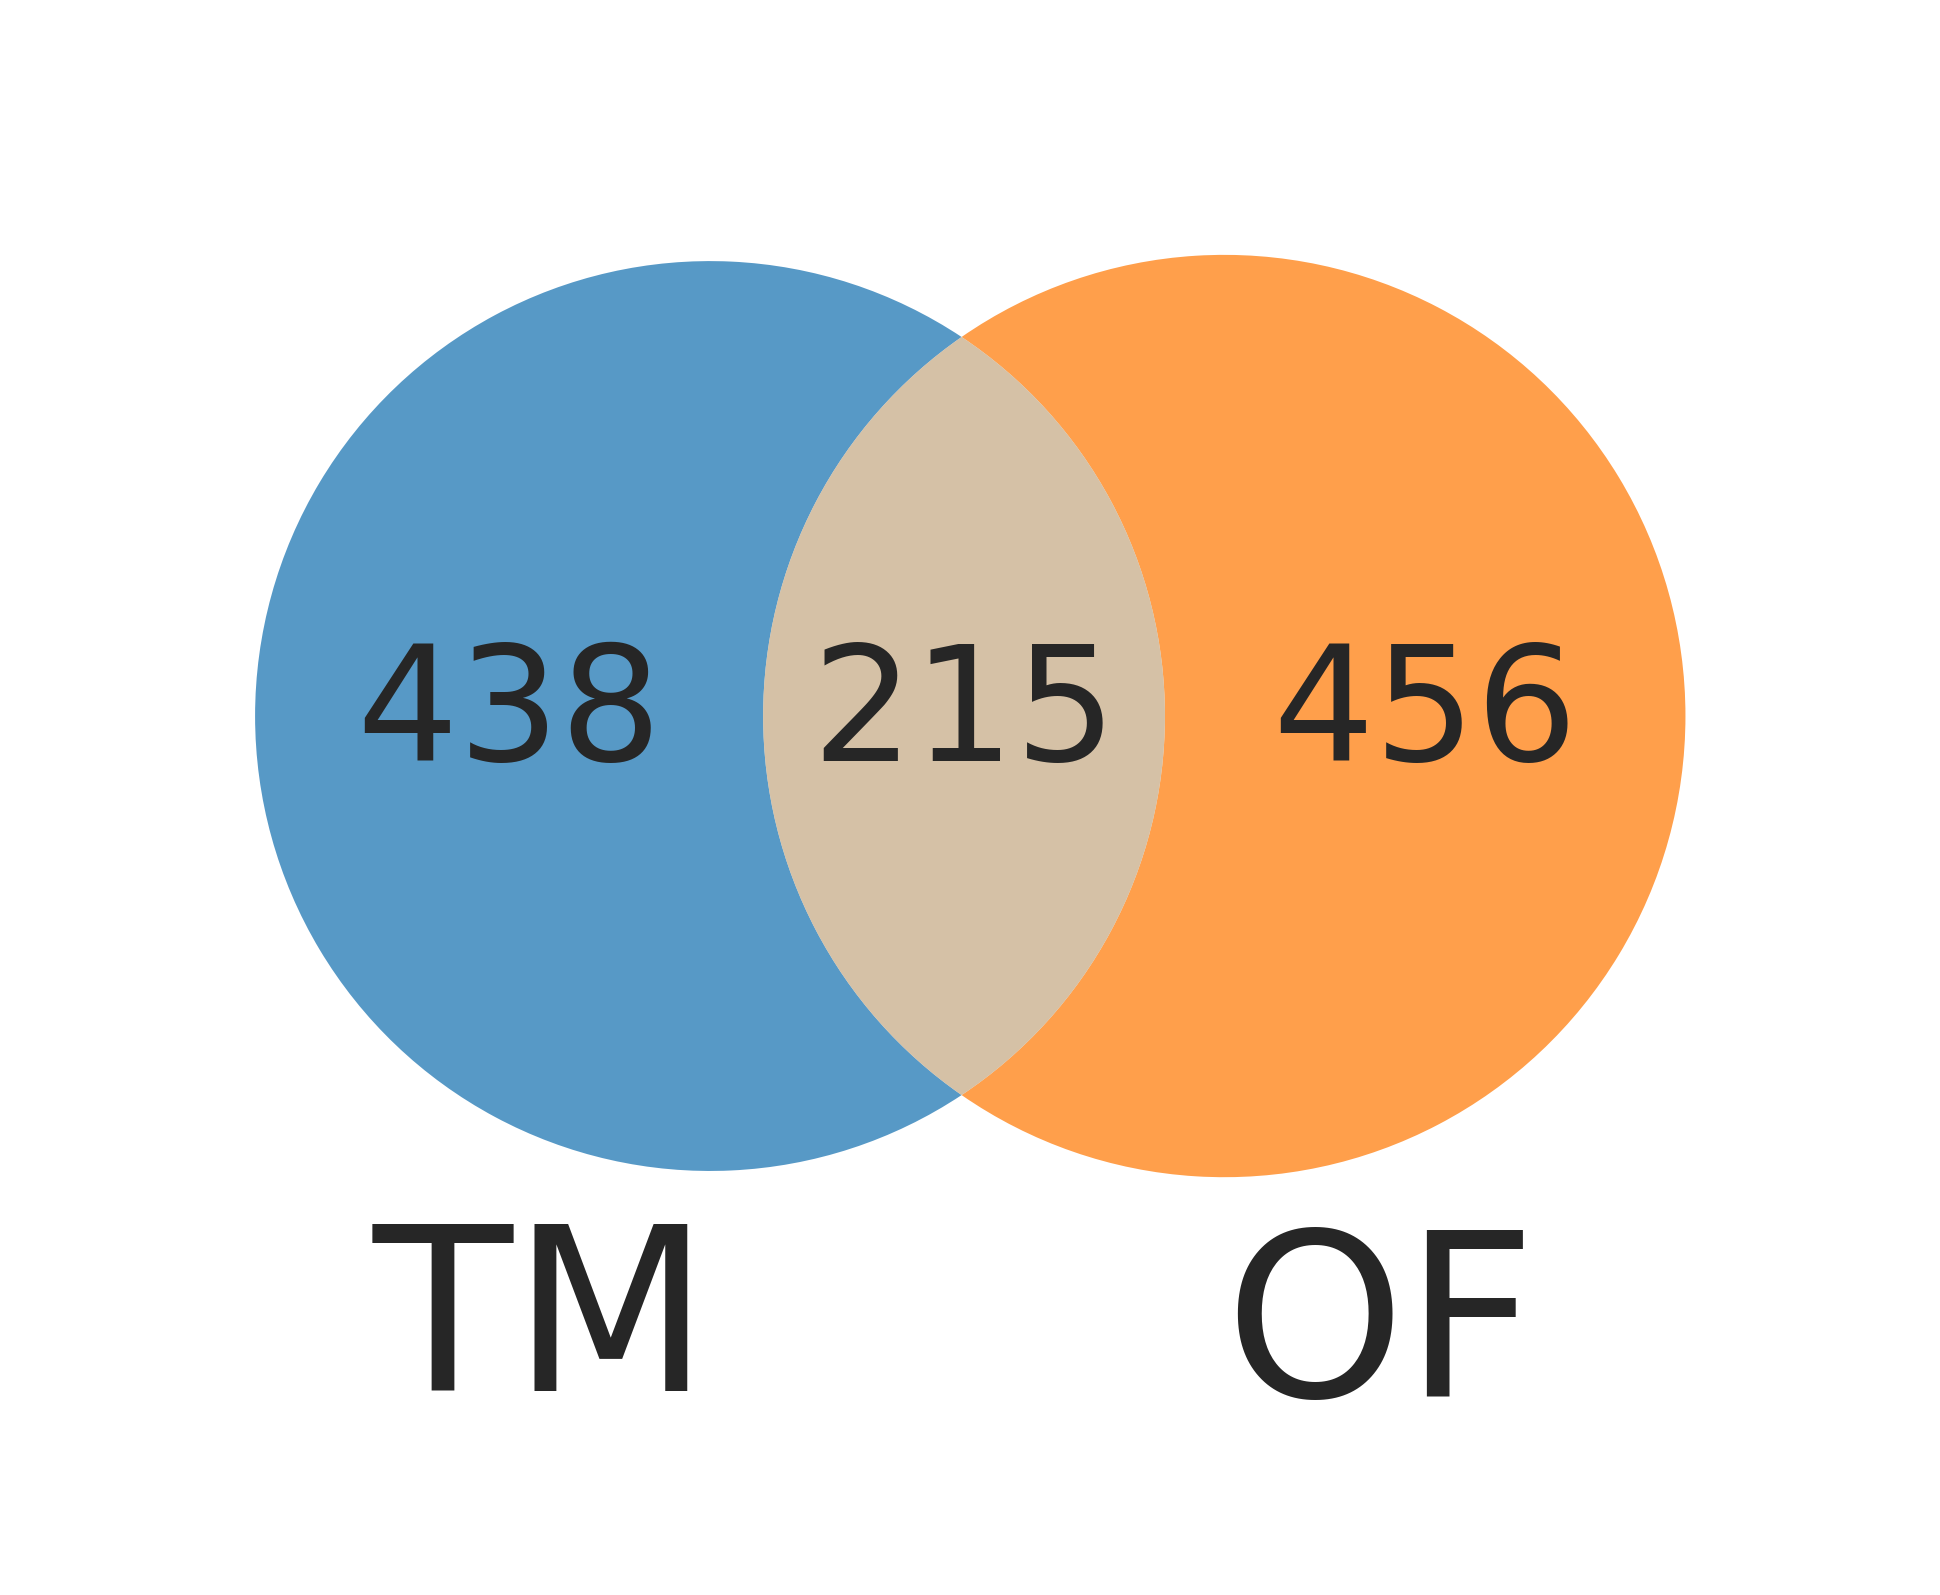

In [6]:
pf = reload(pf)
f = pf.CrossTaskFigures()
f.unit_overlap()

# f.savefig(fig5_path/(f'ClusterMatchesXTasks.pdf'), bbox_inches='tight', dpi=600)
# f.savefig(fig5_path/(f'ClusterMatchesXTasks.png'), bbox_inches='tight', dpi=600)

#### number of matched OF/T3 sessions, and sessions with multiple matches on each

In [788]:
T = pd.crosstab(unit_table.match_lib_multi_task_id[matched_units], unit_table.task2[matched_units]).value_counts()
print(T), print(T.sum())

OF  T3
1   1     141
2   1      37
1   2      30
2   2       4
3   1       2
1   3       1
dtype: int64
215


(None, None)

In [789]:
215-141, 73/215

(74, 0.3395348837209302)

In [14]:
ei = reload(ei)
info = ei.SummaryInfo()

match_table = info.get_unit_match_table()
combined_scores_table = info.get_combined_scores_matched_units(overwrite=True)

In [8]:
match_table.head()

,match_cl_id,subject,session_T3,session_OF,cl_id_T3,cl_id_OF,cl_name_T3,cl_name_OF,session_cl_id_T3,session_cl_id_OF,match_pair_number
0,0,Li,Li_T3i_061218_0001,Li_OF_061318,438,458,Li_T3i_061218_0001-tt3_d17.5_cl10,Li_OF_061318-tt3_d17.5_cl1,0,1,0
1,1,Li,Li_T3g_061318,Li_OF_061318,476,460,Li_T3g_061318-tt3_d17.5_cl5,Li_OF_061318-tt3_d17.5_cl15,0,3,0
2,1,Li,Li_T3g_061418,Li_OF_061318,497,460,Li_T3g_061418-tt3_d17.5_cl15,Li_OF_061318-tt3_d17.5_cl15,0,3,1
3,2,Li,Li_T3g_061518,Li_OF_062018,563,638,Li_T3g_061518-tt3_d17.75_cl1,Li_OF_062018-tt3_d17.75_cl0,0,0,0
4,2,Li,Li_T3g_061818,Li_OF_062018,613,638,Li_T3g_061818-tt3_d17.75_cl6,Li_OF_062018-tt3_d17.75_cl0,0,0,1


In [35]:
of_score_names = [c for c in combined_scores_table.columns if 'OF' in c]
tm_score_names = [c for c in combined_scores_table.columns if 'TM' in c]

print("OF Scores")
print(of_score_names)
print()
print("TM Scores")
print(tm_score_names)
combined_scores_table.head()


OF Scores
['OF-agg_sdp-map_r', 'OF-agg_sdp-r2', 'OF-hd-agg_sdp_coef', 'OF-hd-coef', 'OF-hd-map_r', 'OF-hd-r2', 'OF-pos-agg_sdp_coef', 'OF-pos-coef', 'OF-pos-map_r', 'OF-pos-r2', 'OF-speed-agg_sdp_coef', 'OF-speed-coef', 'OF-speed-map_r', 'OF-speed-r2', 'OF-metric_score_border', 'OF-metric_score_grid', 'OF-metric_score_hd', 'OF-metric_score_speed', 'OF-metric_score_pos']

TM Scores
['TM-remap_cue', 'TM-remap_rw', 'TM-stability_tm', 'TM-rate_cue', 'TM-rate_rw', 'TM-global_cue', 'TM-global_rw', 'TM-enc_uz_cue', 'TM-enc_uz_rw', 'TM-fr_uz_cue', 'TM-fr_uz_rw']


,match_cl_id,subject,TM-remap_cue,TM-remap_rw,TM-stability_tm,TM-rate_cue,TM-rate_rw,TM-global_cue,TM-global_rw,TM-enc_uz_cue,...,OF-pos-r2,OF-speed-agg_sdp_coef,OF-speed-coef,OF-speed-map_r,OF-speed-r2,OF-metric_score_border,OF-metric_score_grid,OF-metric_score_hd,OF-metric_score_speed,OF-metric_score_pos
0,0,Li,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.023935,-0.609305,-0.434155,0.529885,0.005991,0.026876,NaN,0.365053,-0.010321,0.290692
1,1,Li,-0.477471,-0.992209,1.047540,0.043149,0.064612,0.036118,0.063609,-0.831522,...,0.120618,0.535622,-1.809844,0.671016,0.082013,0.428171,NaN,0.117746,-0.233768,0.426175
2,1,Li,-0.591937,-1.615437,1.069937,0.073543,0.100555,0.060097,0.088995,-1.511858,...,0.120618,0.535622,-1.809844,0.671016,0.082013,0.428171,NaN,0.117746,-0.233768,0.426175
3,2,Li,0.202963,-1.901687,0.885659,0.023974,0.101113,-0.005791,0.052273,-1.058301,...,0.007299,0.314193,-0.135714,0.436917,0.008919,0.513280,0.008047,0.117182,0.057720,0.408785
4,2,Li,-0.183025,-0.372746,0.613068,0.024433,0.059178,0.019781,0.063531,-0.907115,...,0.007299,0.314193,-0.135714,0.436917,0.008919,0.513280,0.008047,0.117182,0.057720,0.408785


In [192]:

from sklearn.model_selection import KFold
from sklearn.metrics import davies_bouldin_score, silhouette_score

## cluster data according to OF data

In [109]:
%%time
np.random.seed(0)

score_key = 'agg_sdp_coef'
OF_cluster_score_names = [c for c in of_score_names if score_key in c]

X = combined_scores_table[OF_cluster_score_names]

N = 20
K_range = np.arange(2,7)
K = len(K_range)
of_clusters_table = pd.DataFrame(index=range(N*K), columns=['n', 'k', 'score_1', 'score_2', 'score_3'])

cnt =0 
for ii in range(N):
    #method_kwargs = {'n_components': 2, 'n_neighbors': 25, 'min_dist': 0.1} # work well for cells only
    #of_models_umap = UMAP(**method_kwargs).fit_transform(X)
    of_models_umap = X
    for kk in K_range:
        centroids, labels, ss= k_means(of_models_umap, kk)
        ss2 = davies_bouldin_score(of_models_umap, labels)
        ss3 = silhouette_score(of_models_umap, labels)
        of_clusters_table.loc[cnt] = ii, kk, ss, ss2, ss3
        cnt += 1 
# of_clusters = pd.DataFrame(data=np.array((of_models_umap[:,0],of_models_umap[:,1], combined_scores_table['OF-agg_sdp-r2'], labels)).T, index=combined_scores_table.index, columns=['umap_1', 'umap_2', 'r2', 'cluster_id'])
# of_clusters


# plt.scatter(*of_models_umap.T, c=groups, s=combined_scores_table['OF-agg_sdp-r2']*200, cmap='Set1', alpha=0.4)




# c2["of_agg_groups"] = groups
# c2["of_agg_groups"] = c2["of_agg_groups"].astype(dtype='category')


CPU times: user 1min 13s, sys: 1.72 s, total: 1min 15s
Wall time: 3.87 s


<AxesSubplot:xlabel='k', ylabel='score_1'>

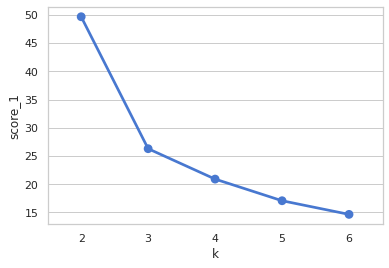

In [114]:
sns.pointplot(data=of_clusters_table, x='k', y='score_1')

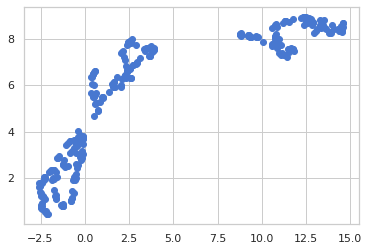

In [98]:
plt.scatter(*of_models_umap.T)

In [87]:
of_clusters_table

,n,k,score_1,score_2
0,0,2,2394.520264,0.521586
1,0,3,742.126099,0.45599
2,0,4,460.992371,0.420393
3,0,5,333.774445,0.363179
4,0,6,210.922989,0.368532
...,...,...,...,...
95,19,2,2413.774414,0.521586
96,19,3,721.628174,0.45599
97,19,4,455.10907,0.420393
98,19,5,320.311401,0.366508


In [477]:
def group_norm(x,mu):
    return np.sqrt( ((x-mu)**2).sum(axis=1)).sum()

def norm_across_groups(X_in,Mu,groups, weighting=None):
    group_labels = np.unique(groups)
    n_groups = len(group_labels)
        
    group_norms = np.zeros(n_groups)
    for ii, g in enumerate(group_labels):
        idx = np.where(groups==g)[0]
        group_norms[ii] = group_norm(X_in[idx], Mu[g])
        
    if weighting == 'median_group_sample_mean':
        weights = 1/np.bincount(groups)
        norm = np.median(group_norms*weights)
    elif weighting == 'mean_group_sample_mean':
        weights = 1/np.bincount(groups)
        norm = np.mean(group_norms*weights)
    elif weighting == 'max_group_sample_mean':
        weights = 1/np.bincount(groups)
        norm = np.max(group_norms*weights)
    elif weighting == 'group_sample_mean':
        weights = 1/np.bincount(groups)
        norm = group_norms@weights
    elif weighting == 'group_mean':
        norm = np.mean(group_norms)
    else:
        norm = group_norms.sum()
    
    
    return norm


In [484]:
%%time

np.random.seed(0)

n_repeats = 2
n_folds = 5
K_range = np.arange(1,7)
K = len(K_range)
n_split = 2
of_clusters_table = pd.DataFrame(index=np.arange(n_repeats*n_folds*K*n_split), columns=['k','fold', 'repeat', 'split', 'score_1', 'score_2', 'score_3', 'score_4'])

cnt = 0
X = combined_scores_table[OF_cluster_score_names].values
for repeat in range(n_repeats):
    method_kwargs = {'n_components': 2, 'n_neighbors': repeat*2+20, 'min_dist': 0.1} 
    X = UMAP(**method_kwargs).fit_transform(combined_scores_table[OF_cluster_score_names])
    
    for kk in K_range:    
        kf = KFold(n_splits=n_folds, shuffle=True)
        fold = 0
        for train_idx, test_idx in kf.split(X):
            Xtrain = X[train_idx]
            Xtest = X[test_idx]
            kmodel = KMeans(n_clusters=kk).fit(Xtrain)
            
            train_predicted_labels = kmodel.predict(Xtrain)
            test_predicted_labels = kmodel.predict(Xtest)
            MU = kmodel.cluster_centers_

            train_score_1 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='group_mean')
            train_score_2 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='group_sample_mean')
            train_score_3 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='mean_group_sample_mean')
            train_score_4 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='median_group_sample_mean')
            
            
            test_score_1 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='group_mean')
            test_score_2 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='group_sample_mean')
            test_score_3 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='mean_group_sample_mean')
            test_score_4 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='median_group_sample_mean')

            of_clusters_table.loc[cnt] = kk, fold, repeat, 'train', train_score_1, train_score_2, train_score_3, train_score_4
            cnt+=1
            of_clusters_table.loc[cnt] = kk, fold, repeat, 'test', test_score_1, test_score_2, test_score_3, test_score_4
            cnt+=1
            
            fold+=1
 

CPU times: user 51.1 s, sys: 1.34 s, total: 52.4 s
Wall time: 6.61 s


In [479]:
of_clusters_table.loc[(cnt-20):cnt]

,k,fold,repeat,split,score_1,score_2,score_3,score_4
100,5,0,1,train,1.309789,5.075113,1.015023,0.931146
101,5,0,1,test,1.248108,5.30583,1.061166,1.01841
102,5,1,1,train,1.290084,5.237466,1.047493,0.94958
103,5,1,1,test,1.257461,4.952617,0.990523,0.979567
104,5,2,1,train,1.244017,5.006148,1.00123,0.944293
105,5,2,1,test,1.444888,5.713835,1.142767,1.095017
106,5,3,1,train,1.270226,5.115779,1.023156,0.952449
107,5,3,1,test,1.36441,5.212979,1.042596,0.970677
108,5,4,1,train,1.285252,5.134984,1.026997,0.964495
109,5,4,1,test,1.328194,5.152781,1.030556,0.922214


Text(0, 0.5, ' RMSE ')

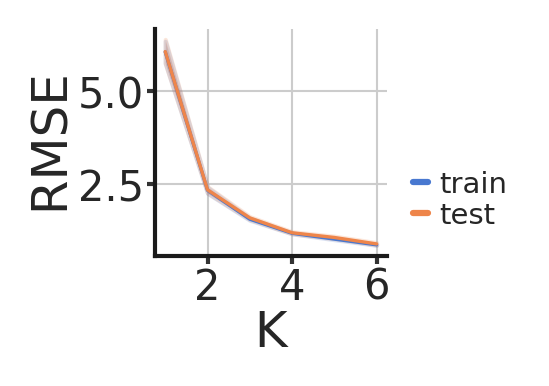

In [488]:
## pf = reload(pf)
f,ax = plt.subplots(figsize=(1,1), dpi=300)
pf.setup_axes(ax)
sns.lineplot(data=of_clusters_table, x='k', y='score_3', hue='split', ax=ax, lw=0.8)

h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ax.set_xlabel(" K ", labelpad=0)
ax.set_xticks([2,4,6])
ax.set_ylabel(" RMSE ", labelpad=0)
#ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2', which='major')

Text(0, 0.5, ' MSE ')

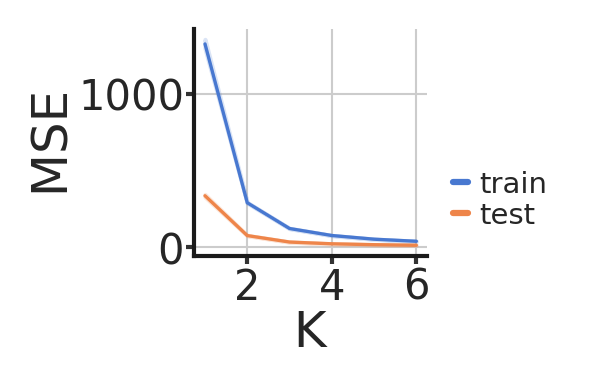

In [390]:
pf = reload(pf)
f,ax = plt.subplots(figsize=(1,1), dpi=300)
pf.setup_axes(ax)
sns.lineplot(data=of_clusters_table, x='k', y='score_2', hue='split', ax=ax, lw=0.8)

h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ax.set_xlabel(" K ", labelpad=0)
ax.set_xticks([2,4,6])
ax.set_ylabel(" MSE ", labelpad=0)

In [489]:
of_clusters_table.k.isin(np.arange(1,6))

of_clusters_table[]


,k,fold,repeat,split,score_1,score_2,score_3,score_4
0,1,0,0,train,1564.233154,6.517638,6.517638,6.517638
1,1,0,0,test,391.321716,6.522029,6.522029,6.522029
2,1,1,0,train,1560.050415,6.50021,6.50021,6.50021
3,1,1,0,test,398.973297,6.649555,6.649555,6.649555
4,1,2,0,train,1558.795166,6.49498,6.49498,6.49498
...,...,...,...,...,...,...,...,...
115,6,2,1,test,8.463124,4.932834,0.822139,0.873737
116,6,3,1,train,35.296279,5.231533,0.871922,0.840617
117,6,3,1,test,8.833746,5.210477,0.868413,0.870185
118,6,4,1,train,34.560963,5.114169,0.852361,0.831828


In [498]:
xx = of_clusters_table.groupby(['k', 'split']).mean()
xx

fold  repeat      score_1   score_2   score_3   score_4
k split                                                         
1 test    2.0     0.5   362.676691  6.044612  6.044612  6.044612
  train   2.0     0.5  1448.487952  6.035366  6.035366  6.035366
2 test    2.0     0.5    74.560161  4.698892  2.349446  2.349446
  train   2.0     0.5   296.630058  4.674982  2.337491  2.337491
3 test    2.0     0.5    32.314568  4.804981  1.601660  1.544685
  train   2.0     0.5   126.438226  4.698098  1.566033  1.482227
4 test    2.0     0.5    19.200192  4.812852  1.203213  1.222898
  train   2.0     0.5    75.666432  4.753197  1.188299  1.212114
5 test    2.0     0.5    13.240611  5.389284  1.077857  1.048286
  train   2.0     0.5    50.553825  5.170942  1.034188  1.028355
6 test    2.0     0.5     9.175249  5.430843  0.905141  0.892055
  train   2.0     0.5    35.773638  5.284015  0.880669  0.849216

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


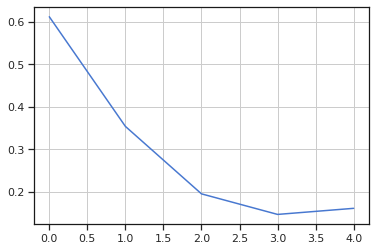

In [506]:
xx = of_clusters_table.groupby('k').mean()
x = xx.iloc[:-1,5].values
y = xx.iloc[1:,5].values

plt.plot((x-y)/x)
#plt.plot((xx.iloc[:-1,2].values-xx.iloc[1:,2].values)
# plt.plot(np.arange(2,7), 1-(xx[:-1,0]-xx[1:,0])/xx[0,0], '-o', lw=3)
# plt.plot(np.arange(2,7), 1-(xx[:-1,1]-xx[1:,1])/xx[0,1], '-o', lw=3)


In [299]:
xx = of_clusters_table.groupby('k').mean().reset_index()
xx
xx[['train_score','test_score']].diff(-1)

# sns.pointplot(data=xx, x='k', y='train_score')
# sns.pointplot(data=xx, x='k', y='test_score', color='r')

,train_score,test_score
0,3.833276,3.839102
1,0.796019,0.790310
2,0.370544,0.369934
3,0.167243,0.149147
4,0.155759,0.176603
5,NaN,NaN


In [298]:
xx.diff?

Signature: xx.diff(periods: 'int' = 1, axis: 'Axis' = 0) -> 'DataFrame'
Docstring:
First discrete difference of element.

Calculates the difference of a Dataframe element compared with another
element in the Dataframe (default is element in previous row).

Parameters
----------
periods : int, default 1
    Periods to shift for calculating difference, accepts negative
    values.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Take difference over rows (0) or columns (1).

Returns
-------
Dataframe
    First differences of the Series.

See Also
--------
Dataframe.pct_change: Percent change over given number of periods.
Dataframe.shift: Shift index by desired number of periods with an
    optional time freq.
Series.diff: First discrete difference of object.

Notes
-----
For boolean dtypes, this uses :meth:`operator.xor` rather than
:meth:`operator.sub`.
The result is calculated according to current dtype in Dataframe,
however dtype of the result is always float64.

Examples
--------

In [217]:
np.cumsum(xx[:-1,0]-xx[1:,0])/xx[0,0]

array([0.8541047 , 0.94710102, 0.96664244, 0.97691966, 0.98407146])

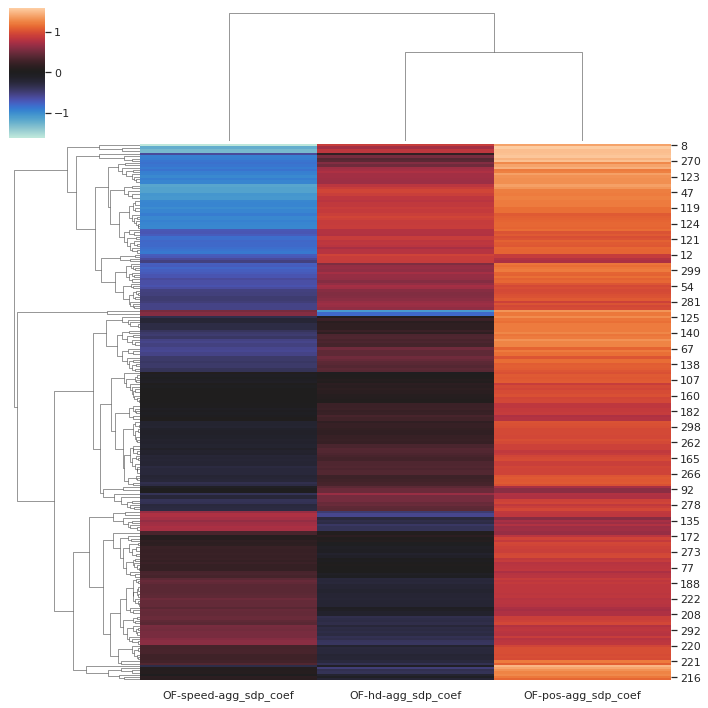

In [159]:
sns.clustermap(Xtrain, center=0)

<AxesSubplot:xlabel='umap_1', ylabel='umap_2'>

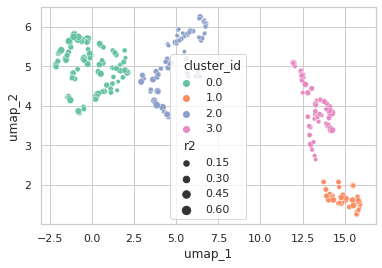

In [60]:
sns.scatterplot(data=of_clusters, x='umap_1', y='umap_2', hue='cluster_id', size='r2', palette='Set2')

In [63]:
means

array([[-0.11694479,  4.944154  ],
       [14.929213  ,  1.6485224 ],
       [ 5.135642  ,  5.0742974 ],
       [13.150829  ,  3.9732122 ]], dtype=float32)

(300,)

In [29]:
score_key = 'agg_sdp_coef'
OF_cluster_scores = [c for c in of_scores if score_key in c]
OF_cluster_scores

['OF-hd-agg_sdp_coef', 'OF-pos-agg_sdp_coef', 'OF-speed-agg_sdp_coef']

Text(0, 0.5, 'OF Model Coefficients')

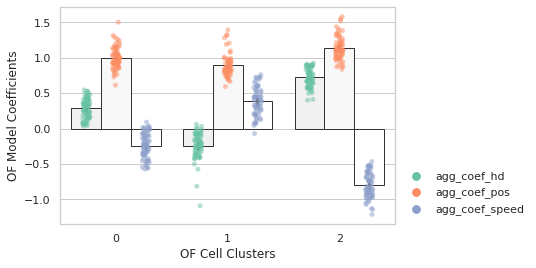

In [1352]:
c3 = c2[of_cols2 + ['of_agg_groups']].melt(id_vars='of_agg_groups')

ax = sns.barplot(data=c3, x='of_agg_groups', y='value', hue='variable', color=[1,1,1,0], edgecolor='0.2')
ax = sns.stripplot(data=c3, x='of_agg_groups', y='value', hue='variable', dodge=True, ax=ax, alpha=0.5, palette="Set2")

h,l = ax.get_legend_handles_labels()

ax.legend(h[:3], l[:3], loc='lower left', bbox_to_anchor=(1,0), frameon=False)
ax.set_xlabel("OF Cell Clusters")
ax.set_ylabel("OF Model Coefficients")

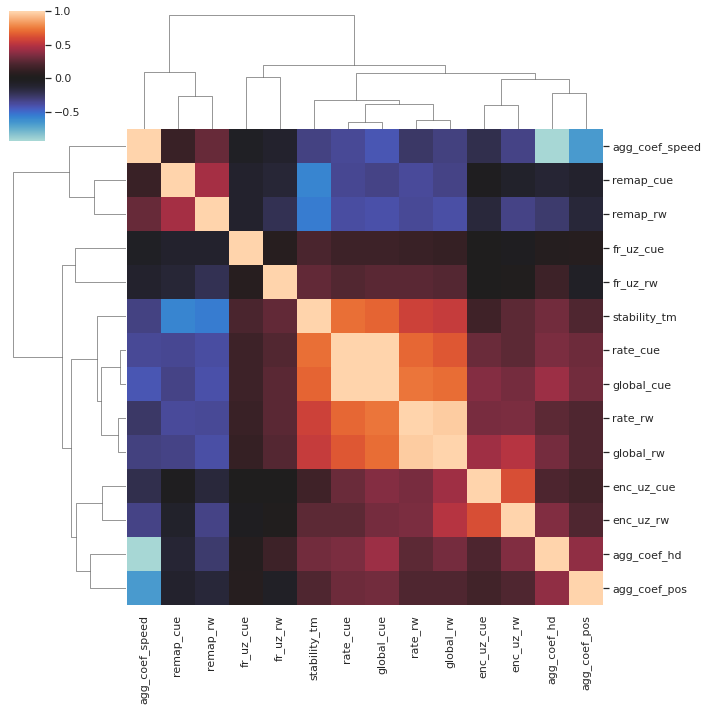

In [1267]:
sns.clustermap(c2[tm_cols + of_cols2].astype(float).corr(method='pearson'), center=0, annot=False)

<AxesSubplot:>

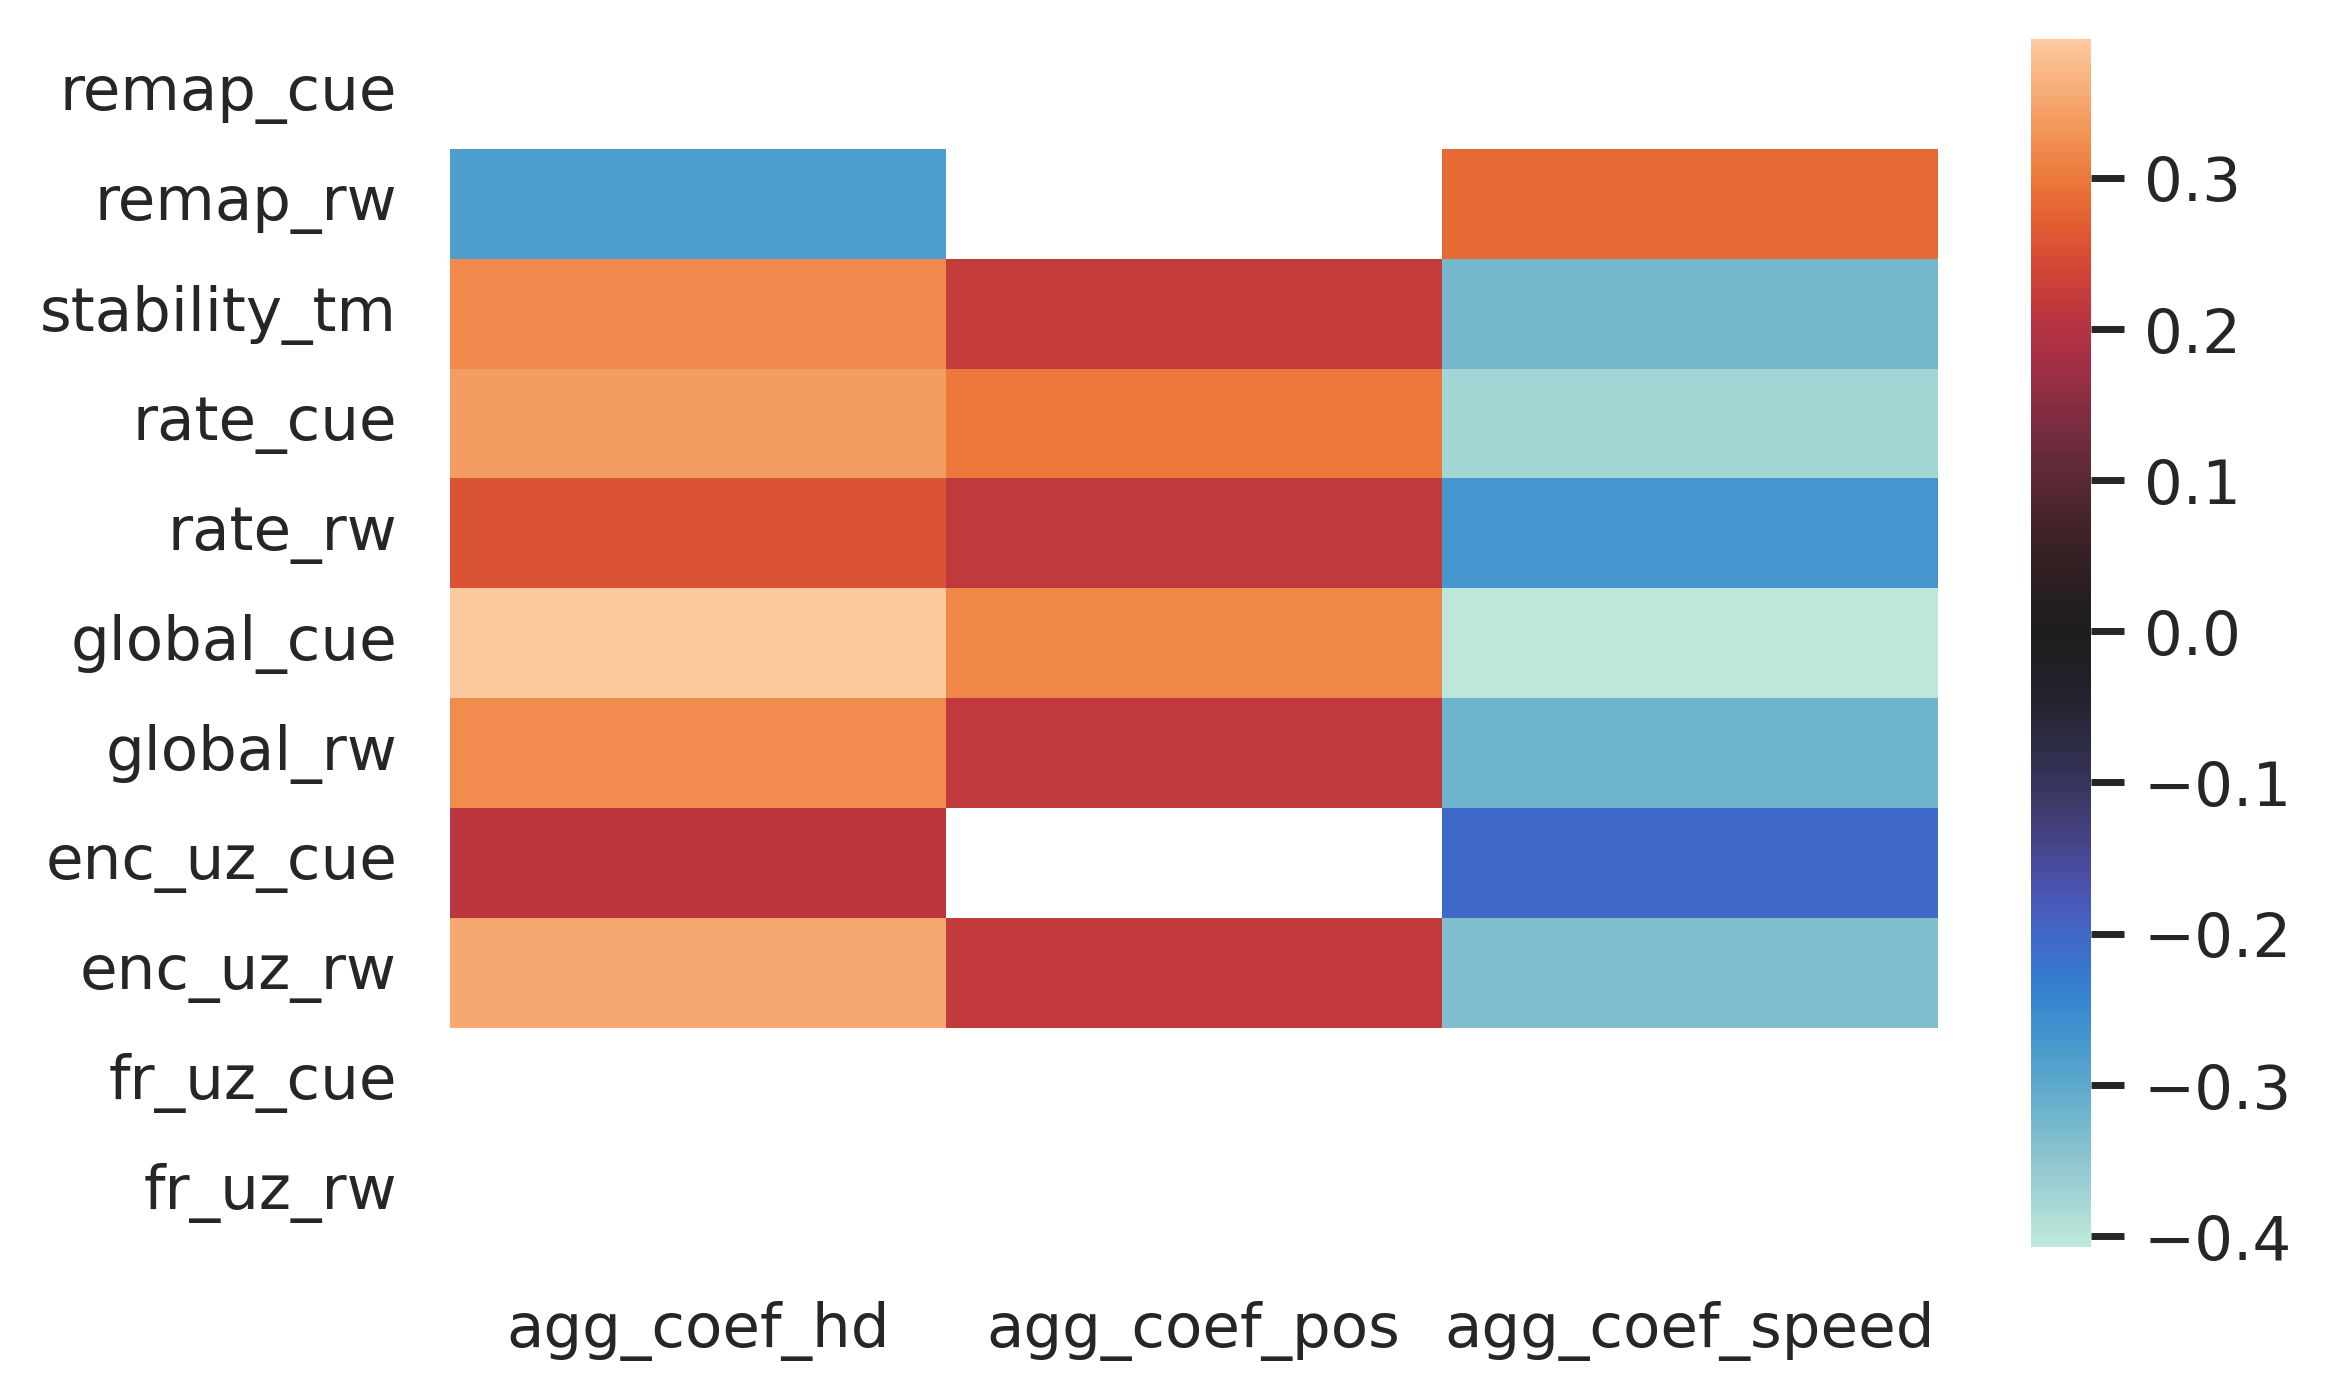

In [1269]:
f,ax=plt.subplots(dpi=400)
c2_sub_corr = c2[cols].corr(method='pearson').loc[tm_cols, of_cols2]
c2_sub_corr_mask = np.abs(c2_sub_corr)<0.2
sns.heatmap(c2_sub_corr, mask=c2_sub_corr_mask, center=0, annot=False, ax=ax, robust=True)

In [1316]:
#tm_var = 'mean_null_cue'
#tm_var = 'uz_cue'
target_var = 'enc_uz_rw'
predictor_vars = tm_cols3 + of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c3 = c2[[target_var, 'subject', 'of_agg_groups']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)}",
                  groups='subject', re_formula='1', data=c3).fit()
#mdf = smf.ols(formula=f"{tm_var} ~ 1 + {'+'.join(of_cols)}", data=c2).fit()
#mdf = smf.rlm(formula=f"{tm_var} ~ 1 + {'+'.join(of_cols)}", data=c2).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  enc_uz_rw
No. Observations:  158      Method:              REML     
No. Groups:        4        Scale:               1.0225   
Min. group size:   3        Log-Likelihood:      -227.0003
Max. group size:   83       Converged:           Yes      
Mean group size:   39.5                                   
----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------
Intercept      -6.664    2.040 -3.267 0.001 -10.662 -2.666
fr_uz_cue      -0.038    0.144 -0.267 0.790  -0.321  0.244
fr_uz_rw       -0.049    0.103 -0.474 0.635  -0.251  0.153
agg_coef_hd     5.759    1.911  3.014 0.003   2.014  9.505
agg_coef_pos    5.487    1.925  2.851 0.004   1.715  9.260
agg_coef_speed  5.109    1.896  2.694 0.007   1.392  8.826
subject Var     0.045    0.068                            
==========================================================

"""

<AxesSubplot:xlabel='of_agg_groups', ylabel='enc_uz_rw'>

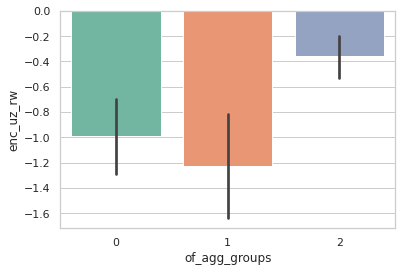

In [1310]:
sns.barplot(x='of_agg_groups', y=target_var, data=c3, palette='Set2')

Group 0 v Group 1
Ttest_indResult(statistic=1.1174869594170216, pvalue=0.2659109603982141)
Group 0 v Group 2
Ttest_indResult(statistic=-3.552488967632898, pvalue=0.0005306204173617921)
Group 1 v Group 2
Ttest_indResult(statistic=-4.487589954202632, pvalue=1.650954435775127e-05)


<AxesSubplot:xlabel='of_agg_groups', ylabel='stability_tm'>

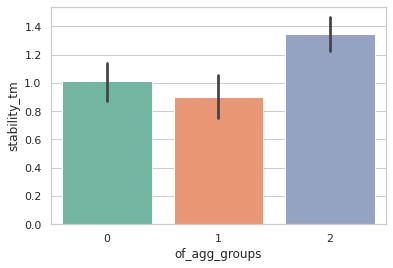

In [1361]:
target_var = "stability_tm"
import scipy.stats as ss
for ii in range(3):
    idx_ii = c2['of_agg_groups']==ii
    for jj in range(ii+1,3):
        idx_jj = c2['of_agg_groups']==jj

        a = ss.ttest_ind(c2[target_var][idx_ii],c2[target_var][idx_jj], 
                         nan_policy='omit', equal_var=False)
        print(f"Group {ii} v Group {jj}")
        print(a)
sns.barplot(x='of_agg_groups', y=target_var, data=c2, palette='Set2')

In [1365]:
c2['subject'][c2['of_agg_groups']==2].value_counts()

Li    34
Cl    19
Ne    13
Name: subject, dtype: int64

0.3764887071823992


<AxesSubplot:xlabel='enc_uz_rw', ylabel='prediction'>

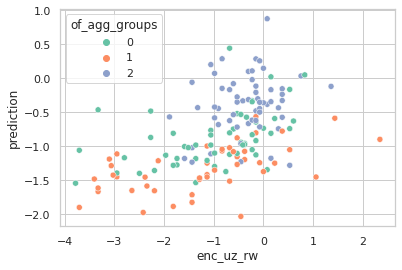

In [1313]:

print(rs.kendall(c3[target_var], mdf.fittedvalues))
c3['prediction'] = mdf.fittedvalues
sns.scatterplot(data=c3, x=target_var, y='prediction', hue='of_agg_groups', palette='Set2',sizes=[10,20])
#plt.plot([-2,0],[-2,0], '--r', lw=3)

In [1132]:
target_var = 'enc_uz_cue'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c4 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c4).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: enc_uz_cue
No. Observations:  158     Method:             REML      
No. Groups:        4       Scale:              0.7841    
Min. group size:   3       Log-Likelihood:     -206.1554 
Max. group size:   83      Converged:          Yes       
Mean group size:   39.5                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -6.097    1.775 -3.435 0.001 -9.577 -2.618
agg_coef_hd     4.618    1.677  2.754 0.006  1.332  7.904
agg_coef_pos    4.689    1.690  2.775 0.006  1.377  8.002
agg_coef_speed  4.451    1.668  2.669 0.008  1.182  7.720
subject Var     0.113    0.135                           
=========================================================

"""

0.37600018377342553


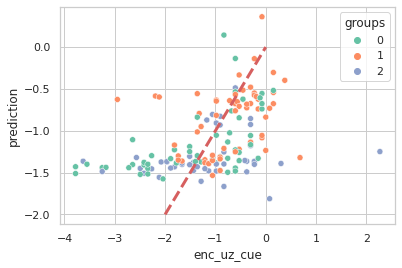

In [1135]:
means, groups, ss= k_means(c4[predictor_vars],3)
c4['groups'] = groups
c4['groups'] = c4['groups'].astype(dtype='category') 
c4['prediction'] = mdf.fittedvalues
print(rs.kendall(c4[target_var], mdf.fittedvalues))
sns.scatterplot(data=c4, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='enc_uz_cue'>

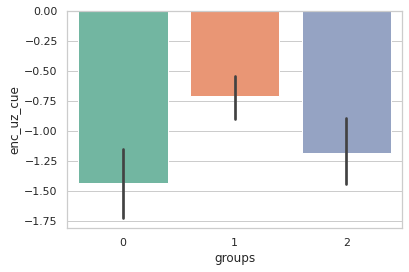

In [1136]:
sns.barplot(x='groups', y=target_var, data=c4, palette='Set2')

In [1149]:
target_var = 'remap_rw'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c5 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c5).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: remap_rw 
No. Observations:   193     Method:             REML     
No. Groups:         5       Scale:              1.0176   
Min. group size:    1       Log-Likelihood:     -277.5149
Max. group size:    109     Converged:          Yes      
Mean group size:    38.6                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -3.185    1.772 -1.798 0.072 -6.657  0.288
agg_coef_hd     1.874    1.586  1.182 0.237 -1.234  4.982
agg_coef_pos    2.115    1.694  1.248 0.212 -1.205  5.434
agg_coef_speed  2.286    1.607  1.423 0.155 -0.864  5.436
subject Var     0.241    0.299                           
=========================================================

"""

0.2664075993091537


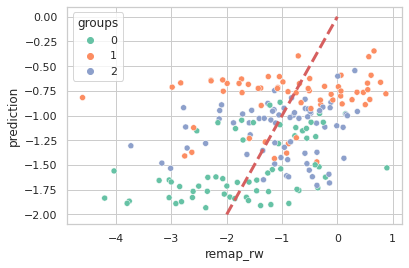

In [1150]:
means, groups, ss= k_means(c5[predictor_vars],3)
c5['groups'] = groups
c5['groups'] = c5['groups'].astype(dtype='category') 
c5['prediction'] = mdf.fittedvalues
print(rs.kendall(c5[target_var], mdf.fittedvalues))
sns.scatterplot(data=c5, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='remap_rw'>

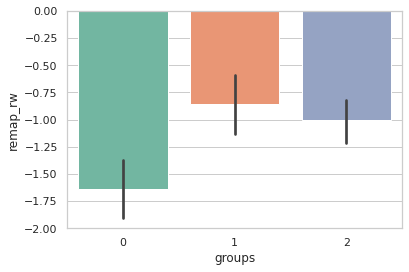

In [1152]:
sns.barplot(x='groups', y=target_var, data=c5, palette='Set2')

<AxesSubplot:>

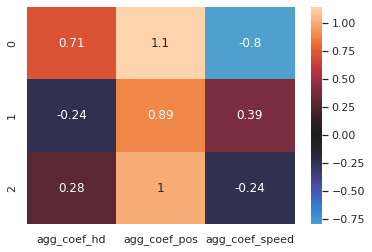

In [1155]:
sns.heatmap(means, xticklabels=predictor_vars, center=0, annot=True)

In [1156]:
target_var = 'remap_cue'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c5 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c5).fit()
    
mdf.summary()

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at t

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: remap_cue
No. Observations:   196     Method:             REML     
No. Groups:         5       Scale:              1.1634   
Min. group size:    1       Log-Likelihood:     -291.8031
Max. group size:    109     Converged:          Yes      
Mean group size:    39.2                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.770    1.821  0.423 0.672 -2.800  4.340
agg_coef_hd    -1.489    1.635 -0.911 0.362 -4.693  1.715
agg_coef_pos   -1.610    1.760 -0.915 0.360 -5.060  1.839
agg_coef_speed -1.245    1.679 -0.742 0.458 -4.537  2.046
subject Var     0.000                                    
=========================================================

"""

0.10423861852433283


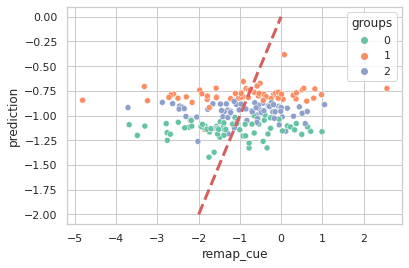

In [1157]:
means, groups, ss= k_means(c5[predictor_vars],3)
c5['groups'] = groups
c5['groups'] = c5['groups'].astype(dtype='category') 
c5['prediction'] = mdf.fittedvalues
print(rs.kendall(c5[target_var], mdf.fittedvalues))
sns.scatterplot(data=c5, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='remap_cue'>

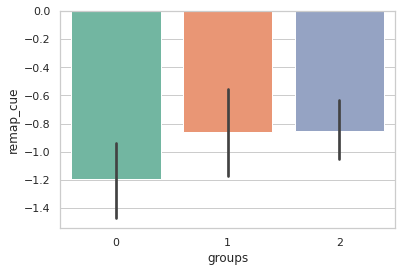

In [1158]:
sns.barplot(x='groups', y=target_var, data=c5, palette='Set2')

<AxesSubplot:>

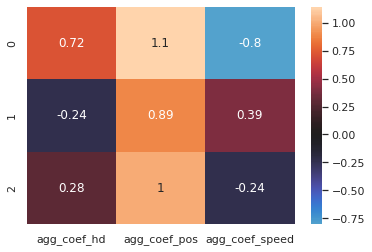

In [1159]:
sns.heatmap(means, xticklabels=predictor_vars, center=0, annot=True)

In [1055]:
y = c2.dropna()[tm_var].values
X = c2.dropna()[of_cols].values

print(of_cols)
B = np.linalg.lstsq(X, y, rcond=None)[0]
print(B)

X2 = np.column_stack((np.ones(X.shape[0]),X))
B2 = np.linalg.lstsq(X2, y, rcond=None)[0]
print(B2)

['r2_hd', 'r2_pos', 'r2_speed', 'agg_coef_hd', 'agg_coef_pos', 'agg_coef_speed', 'coef_score_hd', 'coef_score_pos', 'coef_score_speed', 'metric_score_hd', 'metric_score_speed', 'metric_score_pos']
[-3.33149236 -6.5666128  13.38570195 -1.41119724 -2.34769792 -1.90140325
  0.4655047   1.74677036  0.53760515  1.69466781 -5.12630875  0.90404414]
[-6.38251522 -0.03129842 -7.39767198 12.52123661  4.15467741  4.10471167
  3.67618996  0.57780818  1.46278818  0.44659092 -0.36140105 -4.51019334
  0.83905687]


In [631]:
np.corrcoef((X2@B2), y)[0,1], np.corrcoef((X@B), y)[0,1] 

(0.49559053895996724, 0.46750017864261806)

In [1024]:
from sklearn.cluster import k_means

In [929]:
from sklearn.cross_decomposition import PLSCanonical

plsca = PLSCanonical(n_components=2)

In [959]:
A = c2[tm_cols2[4:]+of_cols2].copy().dropna()
X = A[of_cols2]
Y = A[tm_cols2[4:]]

In [967]:
m=plsca.fit(X,Y)
m.coef_

m.

<bound method RegressorMixin.score of PLSCanonical()>

<AxesSubplot:>

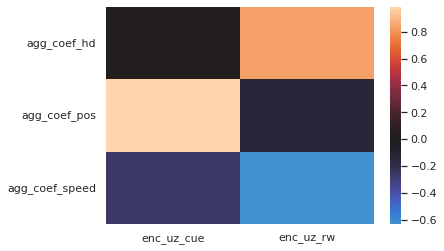

In [966]:
sns.heatmap(m.coef_, xticklabels=tm_cols2[4:], yticklabels=of_cols2, center=0)


In [504]:
col_dict = dict(zip(['Li', 'Ne', 'Cl', 'Ca', 'Al'], mpl.cm.Set1(np.arange(5))))
col_dict

{'Li': array([0.89411765, 0.10196078, 0.10980392, 1.        ]),
 'Ne': array([0.21568627, 0.49411765, 0.72156863, 1.        ]),
 'Cl': array([0.30196078, 0.68627451, 0.29019608, 1.        ]),
 'Ca': array([0.59607843, 0.30588235, 0.63921569, 1.        ]),
 'Al': array([1.        , 0.49803922, 0.        , 1.        ])}

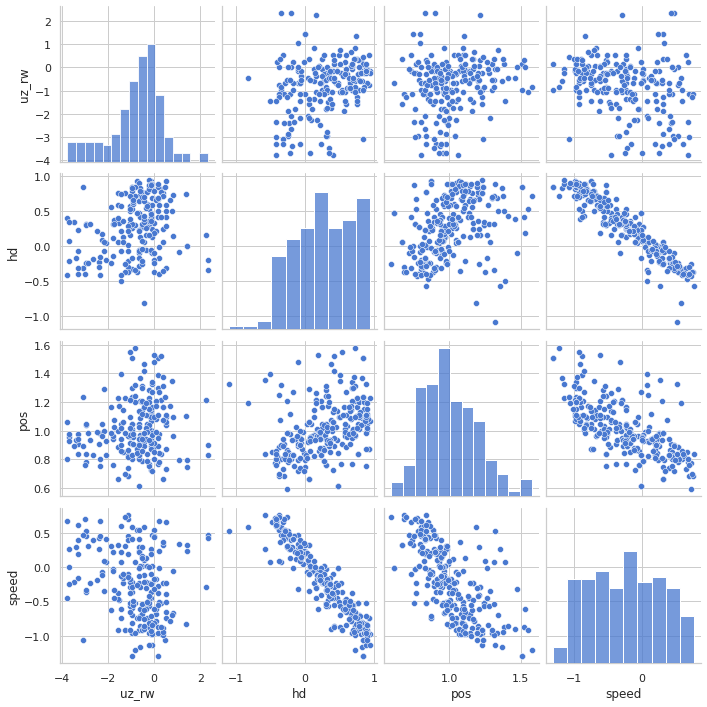

In [512]:
sns.pairplot(combined_table[[tm_var]+of_cols])

In [287]:
mdf.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Robust linear model
=========================================================
Model:              RLM              Df Residuals: 260   
Dependent Variable: rw               Norm:         HuberT
Date:               2022-06-27 15:44 Scale Est.:   mad   
No. Observations:   264              Cov. Type:    H1    
Df Model:           3                Scale:        1.1237
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------
Intercept  -2.1038   1.5973 -1.3171 0.1878 -5.2343 1.0268
hd          0.5739   1.4417  0.3981 0.6906 -2.2517 3.3996
pos         1.0687   1.5396  0.6942 0.4876 -1.9488 4.0862
speed       1.2745   1.4711  0.8664 0.3863 -1.6088 4.1578
=========================================================

"""

In [233]:
?smf.mixedlm

Signature:
smf.mixedlm(
    formula,
    data,
    re_formula=None,
    vc_formula=None,
    subset=None,
    use_sparse=False,
    missing='none',
    *args,
    **kwargs,
)
Docstring:
Create a Model from a formula and dataframe.

Parameters
----------
formula : str or generic Formula object
    The formula specifying the model
data : array_like
    The data for the model. See Notes.
re_formula : str
    A one-sided formula defining the variance structure of the
    model.  The default gives a random intercept for each
    group.
vc_formula : dict-like
    Formulas describing variance components.  `vc_formula[vc]` is
    the formula for the component with variance parameter named
    `vc`.  The formula is processed into a matrix, and the columns
    of this matrix are linearly combined with independent random
    coefficients having mean zero and a common variance.
subset : array_like
    An array-like object of booleans, integers, or index
    values that indicate the subset of df to